In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy

import vc_protocols

In [2]:
VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# # VC_protocol = vc_protocols.lateNav15_CiPA()

In [3]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ord-2011_VC _JKv1.mmt" )    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=-80)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ORD2011"  
sim.simulation.set_constant('cell.mode', 1)    
y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(VC_protocol.get_voltage_change_endpoints()[-1], log_times=None, extra_log=['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL', 'ik1.IK1', 'inal.INaL'])

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol1["I_Na"] = d['ina.INa']
sol1["I_Kr"] = d['ikr.IKr']
sol1["I_Ks"] = d['iks.IKs']
sol1["I_To"] = d['ito.Ito']
sol1["I_CaL"] = d['ical.ICaL']
sol1["I_K1"] = d['ik1.IK1']
sol1["I_NaL"] = d['inal.INaL']
I_total = np.zeros_like(times1)
for i, (name, values) in enumerate(sol1.items()):   
    if i != 0:
        I_total += values
sol1["I_total"] = I_total

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.4275383949279785 seconds ---


In [4]:
from ord2011_v1 import ORD2011
start_time = time.time()

model = ORD2011(VC_protocol)
sim = simulator_scipy.Simulator(model)

# Epicardial setting
sim.model.ina.GNa = 75.0   
sim.model.inal.GNaL = 0.0075*0.6   
sim.model.ito.Gto = 0.02*4
sim.model.ical.PCa = 0.0001*1.2  
sim.model.ikr.GKr = 0.046*1.3  
sim.model.iks.GKs = 0.0034*1.4
sim.model.ik1.GK1 = 0.1908*1.2
sim.model.inaca.Gncx = 0.0008 *1.1
sim.model.inak.Pnak = 30*0.9
sim.model.ikb.GKb = 0.003*0.6
sim.model.inab.PNab = 3.75e-10
sim.model.icab.PCab = 2.5e-8
sim.model.ipca.GpCa = 0.0005

sim.model.ina.G_adj = 1   
sim.model.inal.G_adj = 1
sim.model.ito.G_adj = 1
sim.model.ical.G_adj = 1
sim.model.ikr.G_adj = 1
sim.model.iks.G_adj = 1
sim.model.ik1.G_adj = 1
sim.model.inaca.G_adj = 1
sim.model.inak.G_adj = 1
sim.model.ikb.G_adj = 1
sim.model.inab.G_adj = 1
sim.model.icab.G_adj = 1
sim.model.ipca.G_adj = 1


model.y0[1:] = y0
# y0 = sim.pre_simulate( protocol='constant', pre_step=5000, v0=-80 )   
d = sim.simulate(t_span=[0, VC_protocol.get_voltage_change_endpoints()[-1]], t_eval=None, method='BDF', max_step=1, atol=1e-6, rtol=1e-6) # 1e-12, 1e-14  # 1e-08, 1e-10

sol2 = {}
times2 = d.t
sol2["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d.t)
sol2["I_Na"] = sim.model.current_response_info.get_current(['I_Na'])
sol2["I_Kr"] = sim.model.current_response_info.get_current(['I_Kr'])
sol2["I_Ks"] = sim.model.current_response_info.get_current(['I_Ks'])
sol2["I_To"] = sim.model.current_response_info.get_current(['I_To'])
sol2["I_CaL"] = sim.model.current_response_info.get_current(['I_CaL'])
sol2["I_K1"] = sim.model.current_response_info.get_current(['I_K1'])
sol2["I_NaL"] = sim.model.current_response_info.get_current(['I_NaL'])
I_total = np.zeros_like(times2)
for i, (name, values) in enumerate(sol2.items()):   
    if i != 0:
        I_total += values
sol2["I_total"] = I_total
            
print("--- %s seconds ---"%(time.time()-start_time))

--- 5.09675407409668 seconds ---


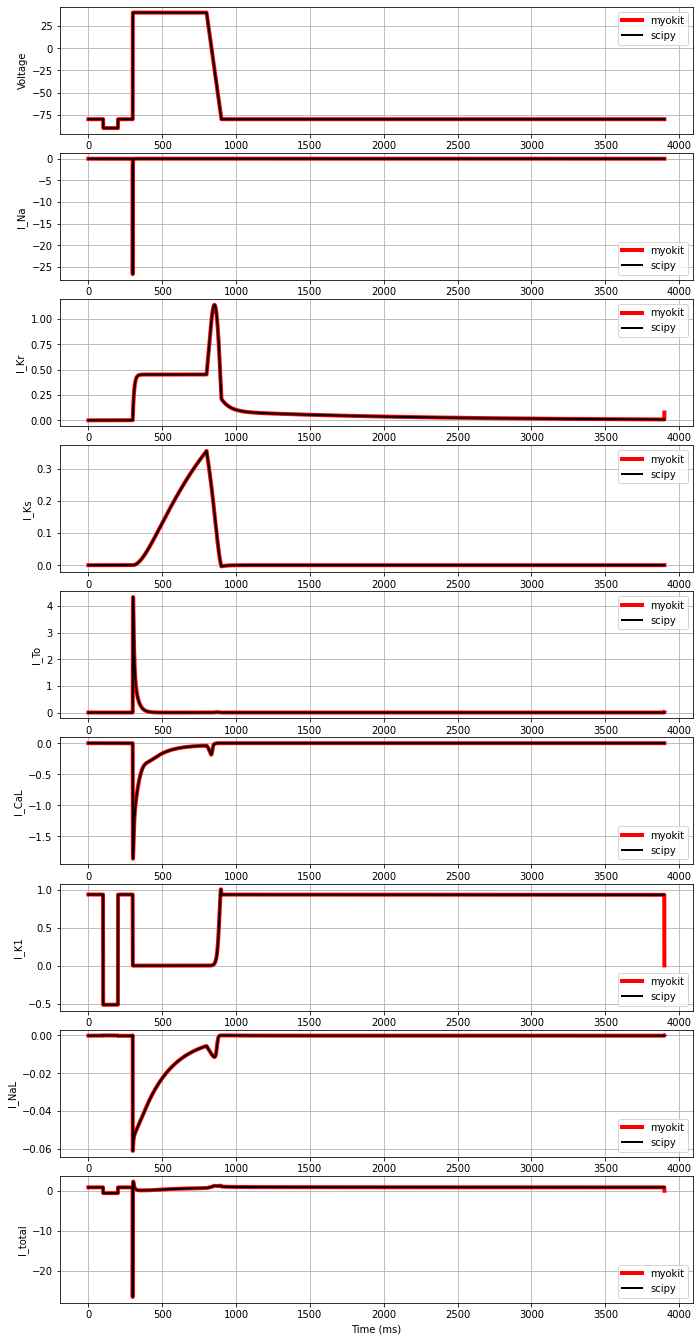

In [5]:
'''
Plot
'''
fig, ax = plt.subplots(len(sol1),1, figsize=(10,20))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol1.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times1, values, label='myokit', color='r', linewidth=4)     
    ax[i].plot( times2, sol2[name], label='scipy', color='k', linewidth=2)    
    ax[i].legend()
    ax[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "Protocol_test.jpg"), dpi=100)